In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
#### Preprocecing ###

In [3]:
jh_dir = "../../COVID-19"

In [4]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [8]:
### Data Preparation ###

In [78]:
country = 'Japan'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-19')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=100000
repeat = 1000

In [79]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [11]:
### Model ###

In [76]:
sm_1 = pystan.StanModel(file="single-step.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97ef2397d791f9f8fddd34e2aa202681 NOW.


In [40]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a5a95e97474fd325a741d7680fda81c NOW.


In [80]:
# Train the model and generate samples
fit_1 = sm_1.sampling(data=data, iter=iteration, init='random', control={'adapt_delta':0.99999})
fit_1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_97ef2397d791f9f8fddd34e2aa202681.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  10.78    0.06   2.52   6.52   8.97  10.56  12.34   16.3   1539   1.01
b0         0.71    0.02   0.64   0.06   0.26   0.52   0.96   2.42   1032    1.0
b1         0.59    0.01   0.53   0.06   0.23   0.44   0.79   2.02   1369    1.0
theta_b    1.01    0.01   0.98   0.03    0.3   0.72   1.41   3.61   5512    1.0
b_date    32.21    1.32  24.22   1.18  15.68  23.77  48.06  77.77    334   1.01
p          0.22  5.7e-3   0.17   0.04    0.1   0.16   0.29   0.68    874    1.0
q0         0.91  3.5e-3   0.08   0.71   0.87   0.93   0.97    1.0    509   1.01
q1         0.47    0.03   0.25   0.09   0.27   0.43   0.67   0.96     60   1.05
theta_q     1.3    0.11   1.18   0.04   0.41 

In [81]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2a5a95e97474fd325a741d7680fda81c.
4 chains, each with iter=100000; warmup=50000; thin=1; 
post-warmup draws per chain=50000, total post-warmup draws=200000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     12.36  8.3e-3   2.35   8.25   10.7  12.19  13.82  17.42  79167    1.0
b             0.49  1.4e-3   0.57   0.04   0.13   0.29   0.61    2.1 167619    1.0
p             0.32  6.6e-4   0.23   0.04   0.12   0.25   0.46   0.88 126612    1.0
q             0.93  8.1e-4   0.06   0.76    0.9   0.95   0.98    1.0   6458    1.0
NI[1]         0.92  1.6e-3   0.66   0.04    0.4   0.81   1.32   2.47 172838    1.0
NI[2]         0.99  1.7e-3    0.7   0.05   0.43   0.86    1.4   2.62 174261    1.0
NI[3]         1.93  2.2e-3   0.81   0.59   1.34   1.84   2.42   3.72 135037    1.0
NI[4]         1.11  2.0e-3   0.81   0.05   0.47   0.96   1.59   3.02 163198    1.0
NI[5]         1.18

In [82]:
# Save models

In [83]:
## Saving results

In [84]:
import pickle
with open("sm1_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_1, 'fit' : fit_1}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
import pickle
with open("sm_const_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
### Load modesl

In [ ]:
with open("sm1_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_1 = data_dict['model']
fit_start_1 = data_dict['fit']
# fit = data_list[1]

In [ ]:
# with open("sm2_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# sm_2 = data_dict['model']
# fit_start_2 = data_dict['fit']
# # fit = data_list[1]

In [ ]:
with open("sm_const_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [ ]:
### Convergence

In [86]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_1 = az.from_pystan(fit_1, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9778e4c090>,
      dtype=object)

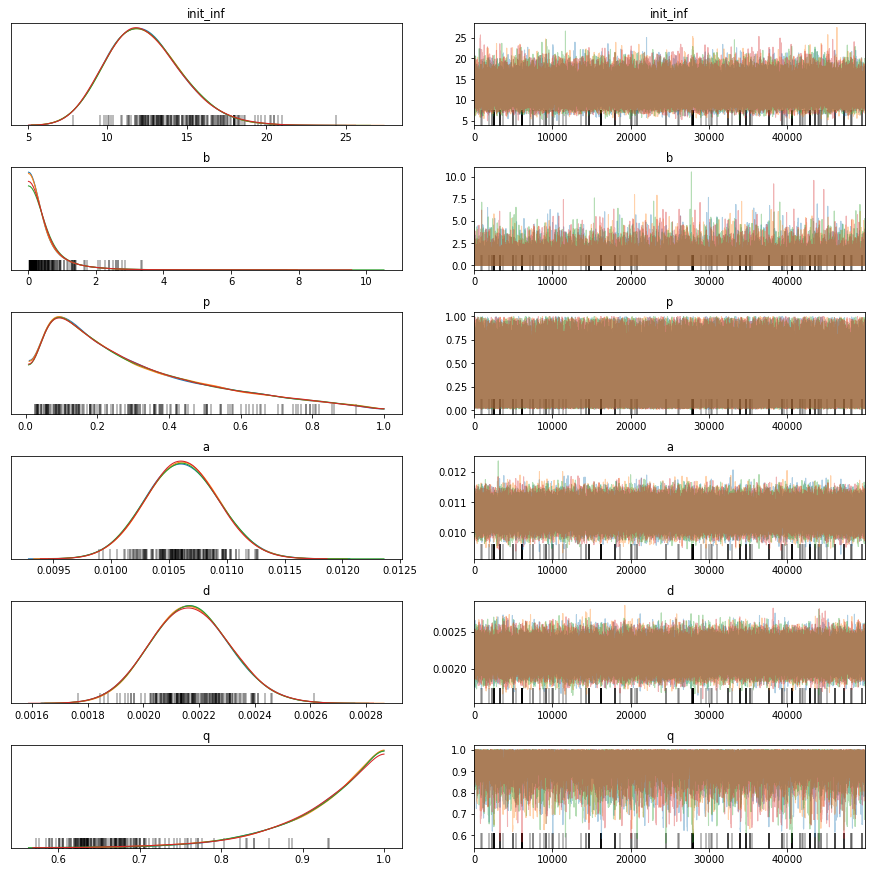

In [88]:
az.plot_trace(data_const, var_names=['init_inf', 'b', 'p', 'a', 'd', 'q'])

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97693d3e10>,
      dtype=object)

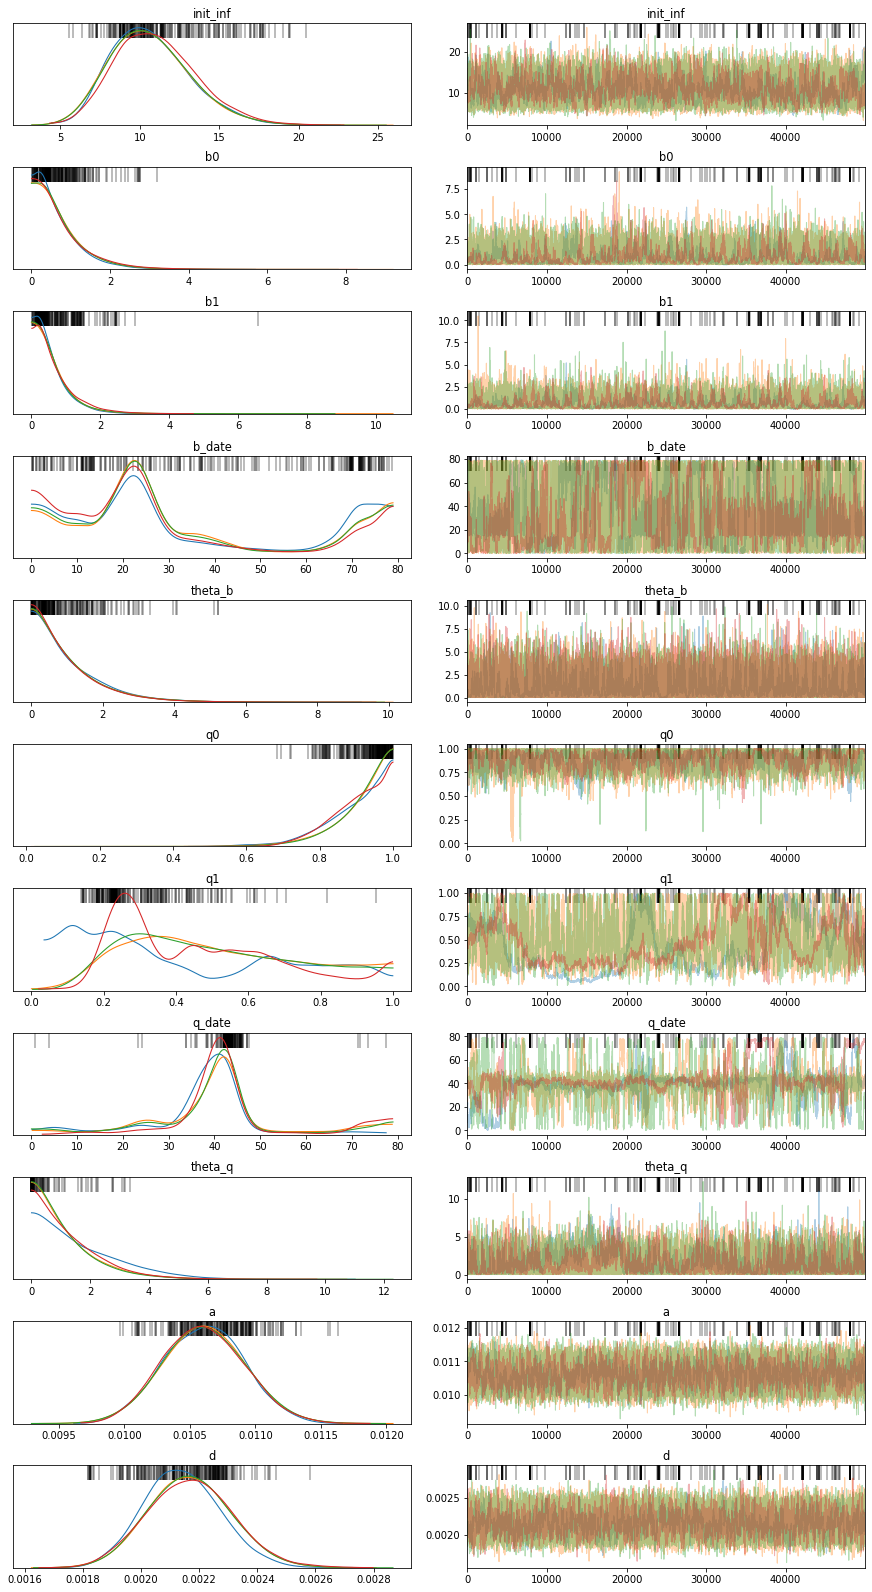

In [89]:
az.plot_trace(data_1, var_names=['init_inf', 'b0', 'b1', 'b_date', 'theta_b', 'q0', 'q1', 'q_date', 'theta_q', 'a', 'd'], divergences='top')

In [19]:
data_1

Inference data with groups:
	> posterior
	> sample_stats

In [ ]:
## Validation by simulation

In [152]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-(x-t0)/theta))

In [310]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, p, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    I = init_inf;
    S_list = [S]
    I_list = [I]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [q0]
    NI_list = [0]
    q = q0 + (q1 - q0) * sigmoid(0, theta_q, q_date)
    S0 = [scipy.stats.poisson.rvs(q * init_inf)]
    R0 = [0]
    D0 = [0]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        growth = (1 - pow(1 - p, b * I / (P - D))) * (P - S);
        NI = scipy.stats.poisson.rvs(max(growth, 0))
        NR = scipy.stats.poisson.rvs(max(a * I, 0))
        ND = scipy.stats.poisson.rvs(max(d * I, 0))
        D = D + ND
        S = S + NI
        R = R + NR
        I = I + NI - NR - ND
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        I_list.append(I)

        NI_list.append(NI)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NI0 = scipy.stats.poisson.rvs(max(q * NI, 0))
        NR0 = scipy.stats.poisson.rvs(a * (S0[-1] - R0[-1] - D0[-1]))
        ND0 = scipy.stats.poisson.rvs(d * (S0[-1] - R0[-1] - D0[-1]))
        S0.append(S0[-1]+NI0)
        R0.append(R0[-1]+NR0)
        D0.append(D0[-1]+ND0)
        
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'I':np.array(I_list),
                        'NI':np.array(NI_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0),
                        'D0':np.array(D0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [280]:
simulate(1, 1, 1, 1, 30, 1, 1, 1, 10,
             0.1, 0.01, 0.1, 120)

I:1, S:1, growth:0.1053605194302909, P-S:119999999
I:1, S:1, growth:0.1053605194302909, P-S:119999999
I:2, S:2, growth:0.1053605194302909, P-S:119999998
I:2, S:2, growth:0.21072102378189705, P-S:119999998
I:2, S:2, growth:0.21072102378189705, P-S:119999998
I:3, S:3, growth:0.21072102378189705, P-S:119999997
I:2, S:3, growth:0.3160815397001707, P-S:119999997
I:2, S:3, growth:0.2107210220258885, P-S:119999997
I:2, S:3, growth:0.2107210220258885, P-S:119999997
I:2, S:3, growth:0.2107210220258885, P-S:119999997
I:2, S:3, growth:0.2107210220258885, P-S:119999997
I:2, S:3, growth:0.2107210220258885, P-S:119999997
I:3, S:4, growth:0.2107210220258885, P-S:119999996
I:4, S:5, growth:0.3160815370661578, P-S:119999995
I:3, S:5, growth:0.4214420503504185, P-S:119999995
I:3, S:5, growth:0.31608153443214493, P-S:119999995
I:3, S:5, growth:0.31608153443214493, P-S:119999995
I:2, S:5, growth:0.31608153443214493, P-S:119999995
I:2, S:5, growth:0.21072101851387137, P-S:119999995
I:2, S:5, growth:0.21072

,S,R,D,b,q,I,NI,S0,R0,D0
2020-02-01,1,0,0,1.0,1.0,1,0,3,0,0
2020-02-02,1,0,0,1.0,1.0,1,0,3,0,0
2020-02-03,1,0,0,1.0,1.0,1,0,3,0,0
2020-02-04,2,0,0,1.0,1.0,2,1,4,0,0
2020-02-05,2,0,0,1.0,1.0,2,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-05-27,11,10,1,1.0,1.0,0,0,15,12,3
2020-05-28,11,10,1,1.0,1.0,0,0,15,12,3
2020-05-29,11,10,1,1.0,1.0,0,0,15,12,3
2020-05-30,11,10,1,1.0,1.0,0,0,15,12,3


In [286]:
fit_1['NI[77]'].mean() * fit_1['q[77]'].mean()

756.3101950515578

In [319]:
fit_1['b1'].mean()*fit_1['p'].mean()

0.12841944053465815

In [318]:
fit_1['d'].mean()

0.0021631977288989494

In [287]:
C0[78]-C0[77]

501

In [294]:
i = 0
fit = fit_1
horizon=(pd.to_datetime('2020-04-18') - pd.to_datetime('2020-02-01')).days
df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      p=fit['p'][i],
                      horizon=horizon)
df['NI']

2020-02-01      0
2020-02-02      2
2020-02-03      2
2020-02-04      0
2020-02-05      5
             ... 
2020-04-14    544
2020-04-15    581
2020-04-16    623
2020-04-17    642
2020-04-18    722
Freq: D, Name: NI, Length: 78, dtype: int64

In [243]:
(1 - pow(1 - 0.08, 1.16 * 5000 / 1200_0000)) * 1200_0000

483.6035869000277

In [258]:
C0S

array([  10,   10,   10,   12,   12,   13,   16,   20,   20,   25,   37,
         40,   41,   43,   46,   47,   53,   54,   57,   63,   69,   74,
         77,   84,   97,  101,  115,  120,  136,  149,  160,  180,  196,
        214,  231,  255,  271,  288,  311,  345,  372,  386,  409,  429,
        444,  458,  468,  492,  519,  543,  565,  583,  608,  623,  645,
        669,  705,  746,  791,  839,  898,  946,  994, 1050, 1121, 1195,
       1259, 1326, 1415, 1512, 1592, 1674, 1775, 1892, 2010, 2153, 2295,
       2424])

In [170]:
C0S = df['S0'].values
R0S = df['R0'].values
D0S = df['D0'].values
data_simulated = {'T': C0S.shape[0], 'T0': 0, 'P': P, 'C0': C0S, 'R0': R0S, 'D0':D0S}

In [171]:
# Train the model and generate samples
fit_simulated = sm_1.sampling(data=data_simulated, iter=2000, init='random')
fit_simulated


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_97ef2397d791f9f8fddd34e2aa202681.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.92    0.08   1.97   2.74   4.49   5.68   7.04  10.22    683   1.01
b0         0.98    0.02   0.77   0.13   0.43   0.76   1.32   2.95   1296    1.0
b1         0.36  8.5e-3    0.3   0.05   0.15   0.28   0.49   1.17   1240    1.0
theta_b    0.99    0.06   1.13   0.03   0.24   0.63   1.29   4.15    385   1.01
b_date    16.34    1.31  10.25   7.26  10.58   11.7  16.05  41.93     61   1.07
p          0.24  5.6e-3   0.16   0.05   0.11   0.19   0.31   0.68    864    1.0
q0         0.88  6.4e-3   0.11    0.6   0.82   0.91   0.96    1.0    285    1.0
q1         0.38    0.02   0.16   0.13   0.28   0.35   0.47   0.81     83   1.06
theta_q    1.19    0.04   1.07   0.08   0.38   0.89

In [103]:
i = 0
(fit_1['init_inf'][i], fit_1['b0'][i], fit_1['b1'][i], fit_1['theta_b'][i], 
fit_1['b_date'][i], fit_1['p'][i], fit_1['q0'][i], fit_1['q1'][i], fit_1['theta_q'][i], fit_1['q_date'][7]
,fit_1['a'][i], fit_1['d'][i])

(10.086103099510366,
 1.1655337837236632,
 0.9678729176096799,
 1.6931707760975772,
 65.07266837414191,
 0.08519295504118096,
 0.9294833532399188,
 0.22445483871459226,
 2.3510999091595837,
 43.10381201949918,
 0.010772791196055787,
 0.0022010736818053322)

In [132]:
data_sim = az.from_pystan(fit_simulated, log_likelihood='log_lik')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f981b932790>,
      dtype=object)

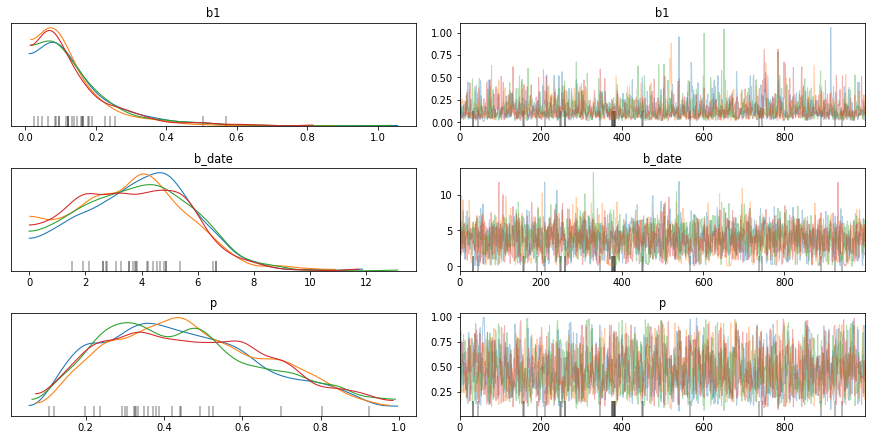

In [151]:
az.plot_trace(data_sim, var_names=['b1', 'b_date', 'p'])

In [ ]:
### Visualization ###

In [320]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    D0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      p=fit['p'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        D0 = pd.concat([D0, df['D0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0'] - df['D0']], axis=1)
    return S, R, D, b, q, S0, R0, I0, D0
    

In [321]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [322]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [323]:
S, R, D, b, q, S0S, R0S, I0S, D0S = monte_carlo(fit_1, 120)

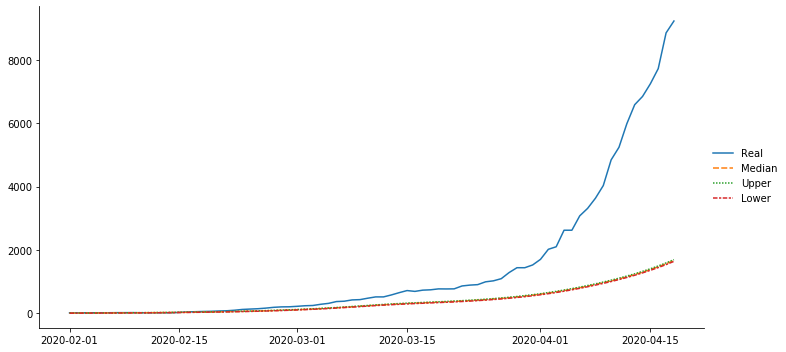

In [324]:
draw(I0S, real=(confirmed-recovered)[country])

In [ ]:
S.median(axis=1)[pd.to_datetime('2020-04-18')]

In [ ]:
draw(q)

In [ ]:
draw(b)

In [ ]:
draw(R0S, real=recovered[country])

In [ ]:
draw(D0S, real=death[country])

In [ ]:
draw(S, upto=pd.to_datetime('2020-05-30'))

In [ ]:
draw(D, upto=pd.to_datetime('2020-05-30'))

In [ ]:
### model selection

In [ ]:
az.loo(data_const)

In [ ]:
az.loo(data_1)

In [ ]:
az.compare({'const':data_const, '1-step':data_1})

In [ ]:
az.loo(data_1, pointwise=True)

In [ ]:
az.loo(data_const, pointwise=True)

In [ ]:
data_CV = {'T': C0.shape[0], 'T0': 50, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [ ]:
# Train the model and generate samples
fit_1_CV = sm_1.sampling(data=data_CV, iter=iteration, init=0)


In [ ]:
v_log_lik = fit_1_CV['v_log_lik']
v_log_lik[~np.isnan(v_log_lik)].mean()

In [ ]:
# Train the model and generate samples
fit_const_CV = sm_const.sampling(data=data_CV, iter=iteration, init=0)
fit_const_CV['v_log_lik'].mean()

In [ ]:
fit_1_CV

In [ ]:
fit_const_CV